In [866]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from scipy.stats import zscore
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

import optuna
import optuna.visualization as vis
import plotly

In [867]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# User Input Fields
train_input_file = "./Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv"
train_labels_file = "./Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv"
test_input_file = "./Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv"
numerical_preprocessing = "StandardScaler"
#numerical_preprocessing = "None"
#categorical_preprocessing = "OneHotEncoder"
categorical_preprocessing = "OrdinalEncoder"
#categorical_preprocessing = "TargetEncoder"

# Possible models: LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier and MLPClassifier.
model_type = "MLPClassifier"
test_prediction_output_file = ""


# Setup fields 
train_pct = 0.8

In [868]:
# Import data from specificed locations

train_values = pd.read_csv(train_input_file)
train_labels = pd.read_csv(train_labels_file)

test_values = pd.read_csv(test_input_file)

numeric_cols = train_values.select_dtypes(include=["int64", "float64"], exclude=["object"]).drop(columns=["id"]).columns
categoric_cols = train_values.select_dtypes(include=["object"], exclude=["int64", "float64"]).columns


# display(train_labels)
# display(train_values)
# display(test_values)
# Label is 'status_group'

In [869]:
# Merging the training values and labels into one dataframe
# train_data = pd.merge(train_values, train_labels, on ='id')
# display(train_data)

# Data Exploration

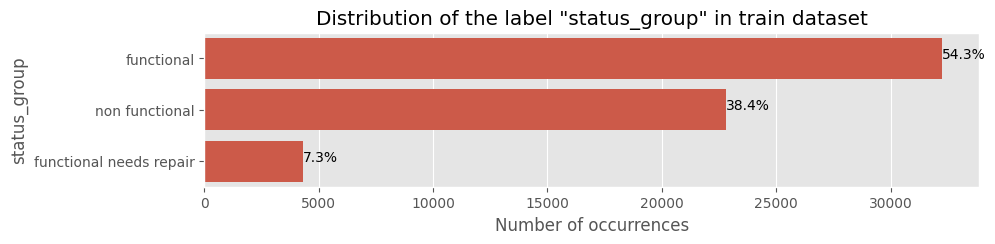

In [870]:
plt.figure(figsize=(10,2))
ax = sns.countplot(y="status_group", data=train_labels)
plt.title('Distribution of the label "status_group" in train dataset')
plt.xlabel('Number of occurrences')
total = len(train_labels)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

In [871]:
# Exploration of data

# Training and test sample count
n_train_samples = len(train_values.index) 
print(f"# Training samples: {n_train_samples}")
n_test_samples = len(test_values.index)
print(f"# Test samples: {n_test_samples}")
print("Number of training samples and labels are equal: " , n_train_samples == len(train_labels))

# Feature count for training data
input_features = train_values.columns
n_features = len(input_features)
print(f"\n# Training features: {n_features}")
print(input_features)

# Label count: unique status_group values in train_labels_file
output_classes = train_labels["status_group"].unique()
print(f"\n# Output classes: {len(output_classes)}")
print(output_classes)


# Training samples: 59400
# Test samples: 14850
Number of training samples and labels are equal:  True

# Training features: 40
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

# Output classes: 3
['functional' 'non functional' 'functional needs repair']


In [872]:
#train_values.head()
#train_values.columns
train_values.describe(include = "all")
# train_values.dtypes
# train_values.shape


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400.000000,59400.000000,59400,55763,59400.000000,55745,59400.000000,5.940000e+04,59398,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400,55522,30590,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,NaN,356,1896,NaN,2145,NaN,NaN,37399,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1,11,2695,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,NaN,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400,36793,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN,NaN,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN,NaN,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [873]:
# Find NaN values for each of the columns
for name, values in train_values.items():
    nan_count = train_values[name].isna().sum()
    print(name + ": " + str(nan_count))


#Did not find any Nan values in numerical features, only in categorical features 
# All missing values are in categorical features, so we can handle the  
# missing values as an additional category when encoding them

id: 0
amount_tsh: 0
date_recorded: 0
funder: 3637
gps_height: 0
installer: 3655
longitude: 0
latitude: 0
wpt_name: 2
num_private: 0
basin: 0
subvillage: 371
region: 0
region_code: 0
district_code: 0
lga: 0
ward: 0
population: 0
public_meeting: 3334
recorded_by: 0
scheme_management: 3878
scheme_name: 28810
permit: 3056
construction_year: 0
extraction_type: 0
extraction_type_group: 0
extraction_type_class: 0
management: 0
management_group: 0
payment: 0
payment_type: 0
water_quality: 0
quality_group: 0
quantity: 0
quantity_group: 0
source: 0
source_type: 0
source_class: 0
waterpoint_type: 0
waterpoint_type_group: 0


In [874]:
# Find possible categories for a given feature
# featurename = "funder"
# train_values.value_counts(subset= featurename, dropna=False)

### Data Exploration: Categorical features

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']



In [875]:
# date_recorded
# this feature is read as strings by the dataframe. Therefore, by default, they'll be treated as categorical features. But that doesn't really make sense.
# It will be preprocessed and transformed into a numerical features 

In [876]:
# funder
var = "funder"
print("The " + var + " variable has " + str(len(train_values.funder.unique())) + " unique categories including NaN.")
# Find possible categories 
print(train_values.value_counts(subset = var, dropna=False))
# If category count is too large: 
train_values.value_counts(subset=var, dropna= False).sort_index(ascending=False).to_csv("output.csv")
# Missing values percentage
percentage_fu=round(train_values[var].isnull().sum()/len(train_values)*100,2)
print("The percentage of missing values in "+ var +" is: " + str(percentage_fu) + "%")

# funder conclusions: 
# We have categories 0 and NaN which are to be considered as missing values 
# We have high volume of low occurrence categories, which can be combined into 'other' category

The funder variable has 1897 unique categories including NaN.
funder
Government Of Tanzania          9084
NaN                             3637
Danida                          3114
Hesawa                          2202
Rwssp                           1374
                                ... 
Mwalimu  Maneromango Muhenzi       1
Mwakifuna                          1
Mwakalinga                         1
Mwakabalula                        1
Mganga                             1
Name: count, Length: 1897, dtype: int64
The percentage of missing values in funder is: 6.12%


In [877]:
# installer
var = "installer"
print("The " + var + " variable has " + str(len(train_values.funder.unique())) + " unique categories including NaN.")
# Find possible categories 
print(train_values.value_counts(subset = var, dropna=False))
# If category count is too large: 
# train_values.value_counts(subset=var, dropna= False).sort_index(ascending=False).to_csv("output.csv")
train_values.value_counts(subset=var, dropna= False).sort_values(ascending=False).to_csv("output.csv")
# Missing values percentage
percentage_fu=round(train_values[var].isnull().sum()/len(train_values)*100,2)
print("The percentage of missing values in "+ var +" is: " + str(percentage_fu) + "%")


# installer observations
# Categories to be treated as missing data: 0, "-"


The installer variable has 1897 unique categories including NaN.
installer
DWE                       17402
NaN                        3655
Government                 1825
RWE                        1206
Commu                      1060
                          ...  
LUWASSA                       1
Prima                         1
Primo                         1
Eastmeru medium School        1
Magoma ADP                    1
Name: count, Length: 2146, dtype: int64
The percentage of missing values in installer is: 6.15%


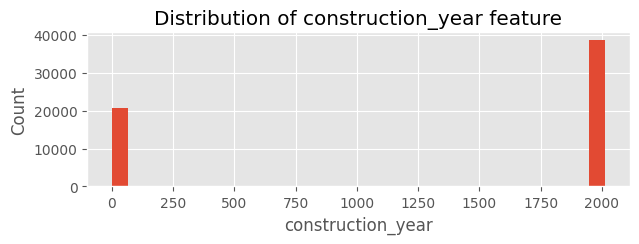

The percentage of rows with 0 in construction_year is: 34.86%.


In [878]:
# Visualisation of numerical features

# Identify features that are numerical
df_num = train_values.select_dtypes(include=["float64", "int64"], exclude=["object"]).drop(columns=["id"])


# construction_year numerical feature
# Construction year = 0 means missing data
plt.figure(figsize=(7,2))
plt.title('Distribution of construction_year feature')
plt.xlabel('construction_year')
plt.ylabel('Count')
feature = "construction_year"
vals = df_num[feature].values # this line takes all values of construction_year column, and put them into a 1-d array
plt.hist(x=vals, bins=30) # show a histogram of the values
plt.show()

percentage = round(((train_values["construction_year"]==0).sum()/len(train_values["construction_year"]!=0)*100),2)
print("The percentage of rows with 0 in construction_year is: " + str(percentage) + "%.")

	
# The percentage of rows with 0 for construction_year is 34.86% so i can get rid of the rows with missing data



    
    

<Figure size 1200x300 with 0 Axes>

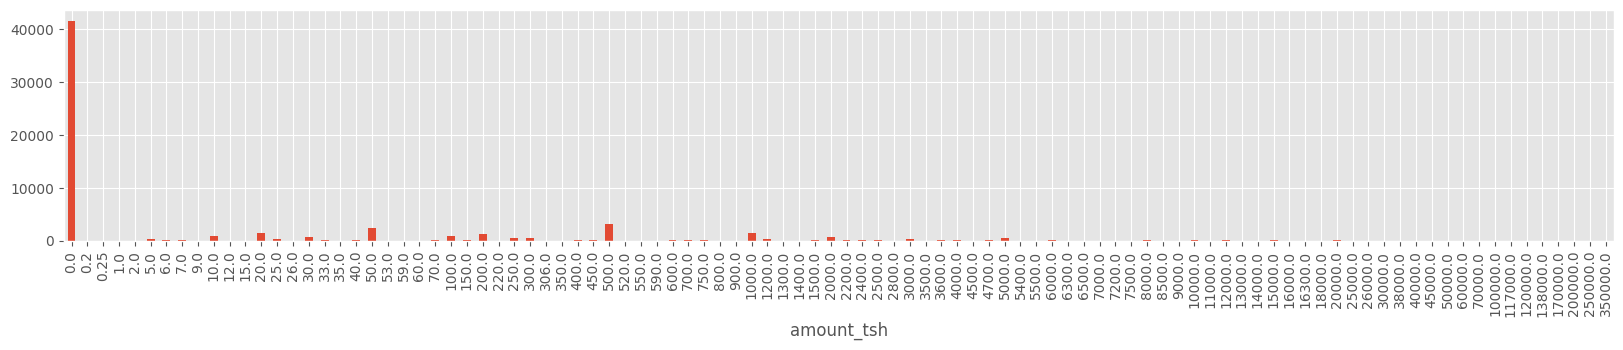

The percentage of rows with 0 in amount_tsh is: 70.1%.


In [879]:
# amount_tsh numerical feature
# TODO Might need to handle some outlier data
# TODO Plot the rest of the numeric features using a loop 
# feature = "amount_tsh"
# plt.hist(df_num[feature], log= True)
# plt.show()

plt.figure(figsize=(12,3))
fig, ax = plt.subplots(figsize=(20,3))
train_values.groupby('amount_tsh').count()['id'].plot(kind="bar",ax=ax)
plt.show()

percentage = round(((train_values["amount_tsh"]==0).sum()/len(train_values["amount_tsh"]!=0)*100),2)
print("The percentage of rows with 0 in amount_tsh is: " + str(percentage) + "%.")

# We assume 0 values in amount_tsh mean that the data is missing
# The percentage of rows with missing data for amount_tsh is 70.1% 
# So we could remove the feature or impute the missing rows

# for f in df_num:
#     print(f)
#     plt.hist(df_num[f])
#     plt.show()

# Assumming the negative values for gps_height are correct as we are dealing with wells 

# Preprocessing

In [880]:
# Preprocessing





# Converting 'date_recorded' into a numerical feature: the number of days since the first recorded date in the dataset.
train_values["date_recorded"] = pd.to_datetime(train_values.date_recorded, format="%Y-%m-%d")

train_values.describe(include = "all")


# find the first recorded date in the training set
first_recorded_date = train_values["date_recorded"].min()
# substract date_recorded column with that first recorded date 
new_dates = train_values["date_recorded"] - first_recorded_date
# convert the new values to the number of days
n_days_since_first = [x.days for x in new_dates]
# replace date_recorded column with the new feature
train_values["date_recorded"] = n_days_since_first

#Re-calculate the numeric and categorical columns 
numeric_cols = train_values.select_dtypes(include=["int64", "float64"], exclude=["object"]).drop(columns=["id"]).columns
categoric_cols = train_values.select_dtypes(include=["object"], exclude=["int64", "float64"]).columns


# TODO visualisa new dates to make sure correct



In [881]:
# # Plotting distribution of all categorical features in provided dataset
# for col in categoric_cols: 
#         plt.figure(figsize=(12,2))
#         ax = sns.countplot(y= col, data=train_values)
#         plt.title('Distribution of the feature ' + col + ' in train dataset')
#         plt.xlabel('Number of occurrences')
#         total = len(train_labels)
#         for p in ax.patches:
#                 percentage = '{:.1f}%'.format(100 * p.get_width()/total)
#                 x = p.get_x() + p.get_width() + 0.02
#                 y = p.get_y() + p.get_height()/2
#                 ax.annotate(percentage, (x, y))
#         plt.plot()
#         plt.show()

In [882]:
# Outlier Handling in Numeric Fields 
# Through imputation for now TODO

# TODO here i am using imputation figure out if that is the best approach 
# Remove every row where construction year is 0 -> this means this data is missing 
mask = train_values['construction_year'] != 0
print(train_values.shape)
train_values_filt = train_values[mask].reset_index(drop=True)
train_labels_filt = train_labels[mask].reset_index(drop=True)
# TODO clean these two lines up
train_values = train_values_filt
train_labels = train_labels_filt
print(train_values.shape)
print(train_labels.shape)


# Removing amount_tsh column from training data
train_values.drop(columns=["id"])



# Detect Outlier through Z Scores
z_scores = np.abs(train_values[numeric_cols].apply(zscore))
threshold = 3
# train_values.describe()
# mask = (np.abs(z_scores) < threshold).all(axis=1)
# non_outlier_values = train_values[mask].reset_index(drop=True)
# non_outlier_labels = train_labels[mask].reset_index(drop=True)
# train_values = non_outlier_values
# train_labels = non_outlier_labels
outliers = (z_scores > threshold).any(axis=1)
print(outliers)
values_clean = train_values[~outliers].reset_index(drop=True)
labels_clean = train_labels[~outliers].reset_index(drop=True)
train_values = values_clean
train_labels = labels_clean

print("New corpus shape after zscore outlier")
print(train_values.shape)
print(train_labels.shape)



(59400, 40)
(38691, 40)
(38691, 2)
0        False
1        False
2        False
3         True
4        False
         ...  
38686    False
38687    False
38688    False
38689    False
38690    False
Length: 38691, dtype: bool
New corpus shape after zscore outlier
(34589, 40)
(34589, 2)


In [883]:
train_values.describe(include = "all")

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,34589.000000,34589.000000,34589.000000,33271,34589.000000,33269,34589.000000,34589.000000,34588,34589.000000,34589,34579,34589,34589.000000,34589.000000,34589,34589,34589.000000,32533,34589,32741,22102,32715,34589.000000,34589,34589,34589,34589,34589,34589,34589,34589,34589,34589,34589,34589,34589,34589,34589,34589
unique,NaN,NaN,NaN,1268,NaN,1382,NaN,NaN,22321,NaN,9,10970,17,NaN,NaN,76,1182,NaN,2,1,11,1793,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,NaN,NaN,NaN,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Pangani,Shuleni,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,Chalinze wate,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,NaN,NaN,5827,NaN,10190,NaN,NaN,2997,NaN,8572,337,4884,NaN,NaN,2466,307,NaN,29869,34589,20199,392,23642,NaN,19075,19075,19075,23115,30061,12205,12205,30335,30335,19942,19942,11914,11914,25076,20213,23570
mean,37127.716153,361.700698,3505.508138,NaN,1078.862644,NaN,35.690284,-5.939246,NaN,0.238949,NaN,NaN,NaN,9.690798,3.367516,NaN,NaN,216.080661,NaN,NaN,NaN,NaN,NaN,1996.836567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21433.062416,1025.679684,348.227762,NaN,588.729978,NaN,2.465485,2.660858,NaN,2.605638,NaN,NaN,NaN,6.593524,3.472530,NaN,NaN,265.277502,NaN,NaN,NaN,NaN,NaN,12.389492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,0.000000,3003.000000,NaN,-63.000000,NaN,29.607122,-11.649440,NaN,0.000000,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1960.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18516.000000,0.000000,3080.000000,NaN,549.000000,NaN,34.611848,-8.110691,NaN,0.000000,NaN,NaN,NaN,4.000000,2.000000,NaN,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,1988.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37147.000000,0.000000,3753.000000,NaN,1216.000000,NaN,36.018703,-5.238757,NaN,0.000000,NaN,NaN,NaN,10.000000,3.000000,NaN,NaN,140.000000,NaN,NaN,NaN,NaN,NaN,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,55541.000000,200.000000,3788.000000,NaN,1519.000000,NaN,37.478720,-3.510525,NaN,0.000000,NaN,NaN,NaN,15.000000,4.000000,NaN,NaN,300.000000,NaN,NaN,NaN,NaN,NaN,2008.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Transform data and fit model

In [884]:
# Categorical Preprocessing

# Handle missing values 
# Handle infrequent categories

# do any of my features have more than 500 categories? if so might need to select top few 
    
# TODO find values that appear less than 1000 times in the datasetco
# TODO maybe the encoders can handle these two situations








In [885]:
# Split the data into train and test sets 
#train_values.set_index('id', inplace=True)
# train_labels.set_index('id', inplace=True)
train_values.drop(columns=["id"], inplace = True)
train_labels.drop(columns=["id"], inplace = True)
X_train, X_val, y_train, y_val = train_test_split(train_values, train_labels, train_size = train_pct)

In [886]:
MIN_FREQ_CAT = 1000  
MAX_CAT = 10

if categorical_preprocessing == "OneHotEncoder":
   encoder = OneHotEncoder(
      min_frequency= MIN_FREQ_CAT
      , max_categories = MAX_CAT
      , handle_unknown='infrequent_if_exist'
      , drop= "first"
      , sparse_output= False # Linear regression performs poorly on sparse data
   )   
elif categorical_preprocessing == "OrdinalEncoder":
   # TODO this will have issues with NaNs -> best practice is to deal with NaNs by imputing or fillna()
   encoder = OrdinalEncoder(
      handle_unknown="use_encoded_value"
      , unknown_value=-1
      , encoded_missing_value= -1 #TODO esto esta bien???
      , dtype=float
      , min_frequency = MIN_FREQ_CAT
      , max_categories = MAX_CAT
   )
elif categorical_preprocessing == "TargetEncoder":
   encoder = TargetEncoder(
      #target_type = "multiclass"
   )
# else: 
# raise error or handle this case



# Transformer object with scaler and encoder
if numerical_preprocessing == "StandardScaler" :
   scaler = StandardScaler(with_mean=True, with_std=True)
else:
   scaler = "passthrough"

preprocessor = ColumnTransformer(
   transformers = [
      ('num', scaler, numeric_cols),
      ('cat', encoder, categoric_cols)],
   verbose=True)


# # Apply to the training data 
# preprocessor.fit(X_train)
# # s = preprocessor.named_transformers_['num']
# # c = preprocessor.named_transformers_['cat']
# # print(s.feature_names_in_)
# # print(c.feature_names_in_)
# # print(s.mean_)

# X_train_transformed = preprocessor.transform(X_train)
X_train_transformed = preprocessor.fit_transform(X_train)
   



[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


In [887]:
print(model_type) # TODO this is debugging
if model_type == "LogisticRegression": 
    model = LogisticRegression(max_iter=400)
    model.fit(X_train_transformed, y_train.values.ravel())
    # model.fit(X_train_transformed, y_train.varavel())
elif model_type == "RandomForestClassifier": 
    model = RandomForestClassifier()
    model.fit(X_train_transformed, y_train.values.ravel())
elif model_type == "GradientBoostingClassifier": 
    model = GradientBoostingClassifier( loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
    model.fit(X_train_transformed, y_train.values.ravel())
elif model_type == "HistGradientBoostingClassifier":
    model = HistGradientBoostingClassifier()
    model.fit(X_train_transformed, y_train.values.ravel())
elif model_type == "MLPClassifier":
    model = MLPClassifier()
    model.fit(X_train_transformed, y_train.values.ravel())

MLPClassifier


# Evaluate model

In [888]:
# calculate classification accuracy of the trained model on the training set
y_train_pred = model.predict(X_train_transformed) # make the predictions
acc_train = accuracy_score(y_pred=y_train_pred, y_true=y_train) # calculate the score
print(f"classification accuracy on the training set: {acc_train:.4f}")


# calculate classification accuracy of the trained model on the validation set
X_val_preprocessed = preprocessor.transform(X_val) # first we need to preprocess the input
y_val_pred = model.predict(X_val_preprocessed) # then make the predictions
acc_val = accuracy_score(y_pred=y_val_pred, y_true=y_val) # calculate the score
print(f"classification accuracy on the validation set: {acc_val:.4f}")

classification accuracy on the training set: 0.8233
classification accuracy on the validation set: 0.7180


In [889]:
# Further evaluation 
# other metrics I can use include these below but the competition rules talked about focusing on accuracy
# Confusion matrix
# F1 score accuracy prediction and recall 

In [890]:
folds = KFold(n_splits=5, random_state=100, shuffle=True)
cv = cross_val_score(estimator=model,
                     X=X_train_transformed,
                     y=y_train.values.ravel(),
                     cv=folds,
                     scoring='accuracy')

print(cv)
print("Mean of the cross validation scores in logistic regression model is: ", cv.mean())
print("Standard dev of the cross validation scores in logistic regression model is: ", cv.std())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.78247516 0.78695338 0.77827973 0.78912179 0.78388146]
Mean of the cross validation scores in logistic regression model is:  0.7841423030300656
Standard dev of the cross validation scores in logistic regression model is:  0.003739376772192159


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [891]:
# Build table using accuracy output of kfold validation for each possible combination
# Amybe use the mean and plot them using heatmap colouring so its nice

In [892]:
# Predict values using the provided test set 
# Output the values to a new file using the given format

# HPO Using Optuna

In [893]:
def objective(trial):
    # Select encoder type
    # OneHotEncoder, OrdinalEncoder, and TargetEncoder.
    encoder_type = trial.suggest_categorical("encoder", ["OneHotEncoder", "OrdinalEncoder", "TargetEncoder"])
    if encoder_type == "OneHotEncoder":
        encoder = OneHotEncoder(
            min_frequency= MIN_FREQ_CAT
            , max_categories = MAX_CAT
            , handle_unknown='infrequent_if_exist'
            , drop= "first"
            , sparse_output= False # Linear regression performs poorly on sparse data 
        )   
    elif encoder_type == "OrdinalEncoder":
        encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value"
            , unknown_value=-1
            , encoded_missing_value= -1 #TODO esto esta bien???
            , dtype=float
            , min_frequency = MIN_FREQ_CAT
            , max_categories = MAX_CAT
        )
    elif encoder_type == "TargetEncoder":
        encoder = TargetEncoder(
            #target_type = "multiclass"
        )


    # Select scaling method
    scaler_type = trial.suggest_categorical("scaler", ["None", "StandardScaler"])
    
    if scaler_type == "StandardScaler":
        scaler = StandardScaler()
    else:
        scaler = "passthrough"
    

    # Select classifier
        #LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier and MLPClassifier.
    classifier_type = trial.suggest_categorical("classifier", ["logistic", "random_forest"])
    
    if classifier_type == "logistic":
        classifier = LogisticRegression(
            C=trial.suggest_float("log_C", 0.01, 10, log=True),
            solver="saga",
            max_iter=500
        )
    else:
        classifier = RandomForestClassifier(
            n_estimators=trial.suggest_int("rf_n_estimators", 50, 300),
            max_depth=trial.suggest_int("rf_max_depth", 3, 20),
            min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("rf_min_samples_leaf", 1, 5)
        )
    
    # Define column transformer
    preprocessor = ColumnTransformer([
        ("encoder", encoder, categoric_cols),
        ("scaler", scaler, numeric_cols)
    ])

    # Create pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])
    
    # Perform cross-validation
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, cv=5, scoring="accuracy").mean()
    
    return score





In [894]:
storage_loc = "sqlite:///optuna_study.db" 
# Optimize using Optuna
study = optuna.create_study(direction="maximize", storage=storage_loc, study_name="HPO_v2")
study.optimize(objective, n_trials=10)

DuplicatedStudyError: Another study with name 'HPO_v2' already exists. Please specify a different name, or reuse the existing one by setting `load_if_exists` (for Python API) or `--skip-if-exists` flag (for CLI).

In [ ]:
# Display best parameters
print("Best parameters:", study.best_params)

Best parameters: {'encoder': 'OrdinalEncoder', 'scaler': 'None', 'classifier': 'random_forest', 'rf_n_estimators': 281, 'rf_max_depth': 18, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 2}


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_40855/2101253297.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = vis.matplotlib.plot_optimization_history(study)
/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_40855/2101253297.py:7: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = vis.matplotlib.plot_param_importances(study)
/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_40855/2101253297.py:11: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  fig3 = vis.matplotlib.plot_intermediate_values(study)
[W 2025-02-12 16:04:10,958] You need to set up the pruning feature to utilize `plot_intermediate_values()`


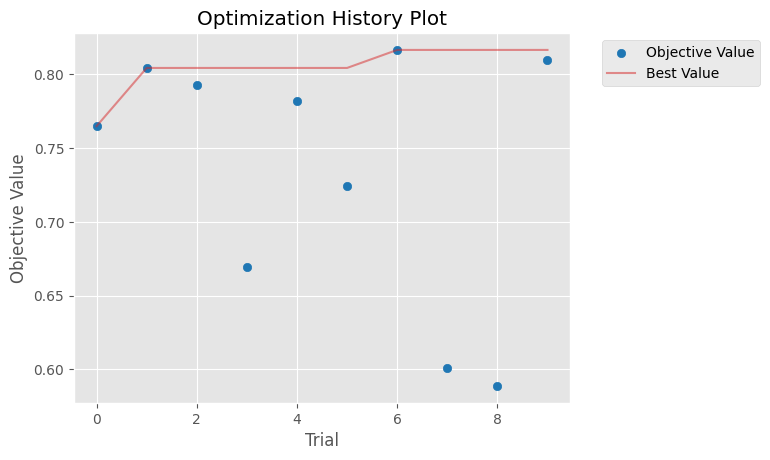

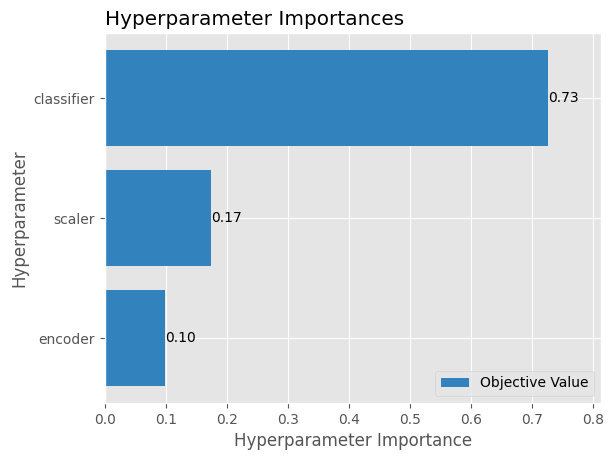

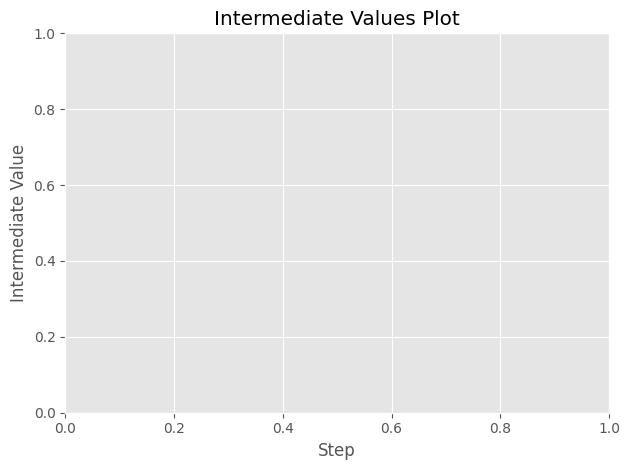

In [ ]:
# Visualize Optimization History
#optuna.visualization.matplotlib.plot_param_importances(study)
fig = vis.matplotlib.plot_optimization_history(study)
#fig.show()

# Visualize Hyperparameter Importance
fig2 = vis.matplotlib.plot_param_importances(study)
#fig2.show()


fig3 = vis.matplotlib.plot_intermediate_values(study)



/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_40855/416096039.py:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_contour(study)
[W 2025-02-12 15:38:29,807] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<Axes: xlabel='classifier', ylabel='classifier'>,
        <Axes: xlabel='encoder', ylabel='classifier'>,
        <Axes: xlabel='log_C', ylabel='classifier'>,
        <Axes: xlabel='rf_max_depth', ylabel='classifier'>,
        <Axes: xlabel='rf_min_samples_leaf', ylabel='classifier'>,
        <Axes: xlabel='rf_min_samples_split', ylabel='classifier'>,
        <Axes: xlabel='rf_n_estimators', ylabel='classifier'>,
        <Axes: xlabel='scaler', ylabel='classifier'>],
       [<Axes: xlabel='classifier', ylabel='encoder'>,
        <Axes: xlabel='encoder', ylabel='encoder'>,
        <Axes: xlabel='log_C', ylabel='encoder'>,
        <Axes: xlabel='rf_max_depth', ylabel='encoder'>,
        <Axes: xlabel='rf_min_samples_leaf', ylabel='encoder'>,
        <Axes: xlabel='rf_min_samples_split', ylabel='encoder'>,
        <Axes: xlabel='rf_n_estimators', ylabel='encoder'>,
        <Axes: xlabel='scaler', ylabel='encoder'>],
       [<Axes: xlabel='classifier', ylabel='log_C'>,
        <Axes

<Figure size 1400x500 with 0 Axes>

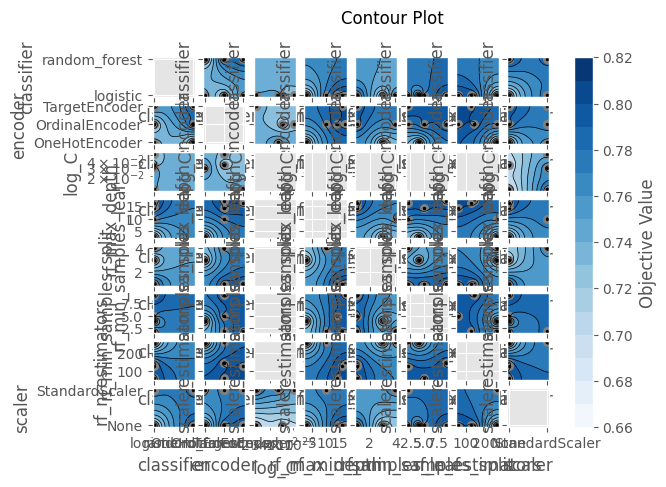

In [ ]:
plt.figure(figsize=(14,5))
plt.tight_layout()
vis.matplotlib.plot_contour(study)

First test of HPO
Best parameters: {'encoder': 'OrdinalEncoder', 'scaler': 'StandardScaler', 'classifier': 'random_forest', 'rf_n_estimators': 286, 'rf_max_depth': 20, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 1}